# Can we predict annotation errors in audio?
In this notebook, I explore a workflow for analysing errors (discrepancies between annotations and model predictions) and deriving features about them using Pyannote models and human feedback. With enough data from this workflow, we could train a classifier to predict whether an error originates from model prediction or annotation.

If we can isolate annotation errors, we can likely discover patterns about when and where they occur. This can help in the creation of better benchmarks and in automating their correction.

### Test on a sample meeting

I am first testing the extraction of errors, features, and human feedback on a single meeting from the [AMI corpus](https://groups.inf.ed.ac.uk/ami/corpus/).

In [26]:
# setting up the API
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("KEY")

In [27]:
import requests

url = "https://api.pyannote.ai/v1/test"

response = requests.get(url, headers={"Authorization": f"Bearer {api_key}"})
print(response.json())

{'status': 'OK', 'message': 'Test connection successful'}


For this project, I'm using the AMI dataset, since its easily accessible and consists of 100 hours of meeting recordings along with speaker labels and timestamps.

In [12]:
# loading in the annotations from the AMI dataset
from datasets import load_dataset

ds = load_dataset("edinburghcstr/ami", "ihm", trust_remote_code=True)

In [13]:
# isolating ground-truth labels from a sample meeting: EN2001a
first_meeting_clips = ds["train"].filter(lambda x: x["meeting_id"] == "EN2001a")
print(first_meeting_clips)

Dataset({
    features: ['meeting_id', 'audio_id', 'text', 'audio', 'begin_time', 'end_time', 'microphone_id', 'speaker_id'],
    num_rows: 1675
})


Now I am running Diarization Precision V1 on the full audio from the sample meeting. A challenge here is the annotated corpus only includes presegmented audio and not the original audio, which requires navigating the webpage to find the publicly available url. Since there is a pattern to these urls, we can likely automate the process of deriving them in order to compare model predictions to the annotations.

Again, for now, we are running the model on just one meeting.

I'm also enabling frame and turn level confidence, since these values will help prioritise which errors to review.

Since I'm running cells in this notebook multiple times, I'm going to save the first pass into json first. I'll then load in the model predictions from that file instead of running the model every time.

In [30]:
# import requests

# url = "https://api.pyannote.ai/v1/diarize"

# headers = {"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"}
# data = {"url": "https://groups.inf.ed.ac.uk/ami/AMICorpusMirror//amicorpus/EN2001a/audio/EN2001a.Mix-Headset.wav",
#         "confidence": True,
#         "turnLevelConfidence": True
#         }

# response = requests.post(url, headers=headers, json=data)

# if response.status_code != 200:
#     print(f"Error: {response.status_code} - {response.text}")
# else:
#     print(response.json())

In [31]:
# import time

# job_id = '0182778d-035c-4833-81a7-d6a299502217'
# headers = {"Authorization": f"Bearer {api_key}"}

# while True:
#     response = requests.get(
#         f"https://api.pyannote.ai/v1/jobs/{job_id}", headers=headers
#     )

#     if response.status_code != 200:
#         print(f"Error: {response.status_code} - {response.text}")
#         break

#     data = response.json()
#     status = data["status"]

#     if status in ["succeeded", "failed", "canceled"]:
#         if status == "succeeded":
#             print("Job completed successfully!")
#             print(data["output"])
#         else:
#             print(f"Job {status}")
#         break

#     print(f"Job status: {status}, waiting...")
#     time.sleep(10)  # Wait 10 seconds before polling again

In [32]:
# # saving result
# import json
# with open('EN2001a.json', 'w') as f:
#     json.dump(data, f)

We want to format the outputs so they can be compared, so we'll use these functions to automate formatting them and future labels into the Pyannote Annotation format. 

In [14]:
from pyannote.core import Annotation, Segment

def pred_to_annotation(data):
    output = data["output"]
    diar = output["diarization"]

    ann = Annotation()
    turn_conf = []   
    frame_conf = None

    # annotation
    for seg in diar:
        start = float(seg["start"])
        end = float(seg["end"])
        speaker = seg["speaker"]

        ann[Segment(start, end)] = speaker

        # turn confidence
        turn_conf.append({
            "start": start,
            "end": end,
            "speaker": speaker,
            "confidence": seg.get("confidence", {})
        })

    # frame level confidence
    if "confidence" in output:
        frame_conf = {
            "scores": output["confidence"]["score"],
            "resolution": output["confidence"]["resolution"]
        }

    return ann, turn_conf, frame_conf

def ami_to_annotation(ds):
    ann = Annotation()

    rows = [
        {
            "speaker": row["speaker_id"],
            "start": row["begin_time"],
            "end": row["end_time"]
        }
        for row in ds
    ]

    for r in rows:
        ann[Segment(float(r["start"]), float(r["end"]))] = str(r["speaker"])

    return ann

In [15]:
import json
with open('EN2001a.json', 'r') as f:
    data = json.load(f)

In [16]:
ref = ami_to_annotation(first_meeting_clips)
hyp, turn_conf, frame_conf = pred_to_annotation(data)

In [36]:
# # saving the hypothesis as rttm
# with open('EN2001a.rttm','w') as f:
#     hyp.write_rttm(f)

Now we can run metrics to analyse errors.
First is DER for reference. This is within the range of what we'd expect!

In [17]:
from pyannote.metrics.diarization import DiarizationErrorRate

metric = DiarizationErrorRate()
der = metric(ref, hyp)
print("DER:", der)

/Users/audri/.pyenv/versions/pyannote/lib/python3.12/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


DER: 0.04272007264501039


Now we can get a comprehensive list of each error and error type.

In [18]:
from pyannote.metrics.errors.identification import IdentificationErrorAnalysis
error_analysis = IdentificationErrorAnalysis(collar=0.5, skip_overlap=False) #500ms collar
errors = error_analysis.difference(ref, hyp)

These look like realistic errors, so we can continue. It might be worth normalising the speaker labels, especially if we want to evaluate speaker confusion errors.

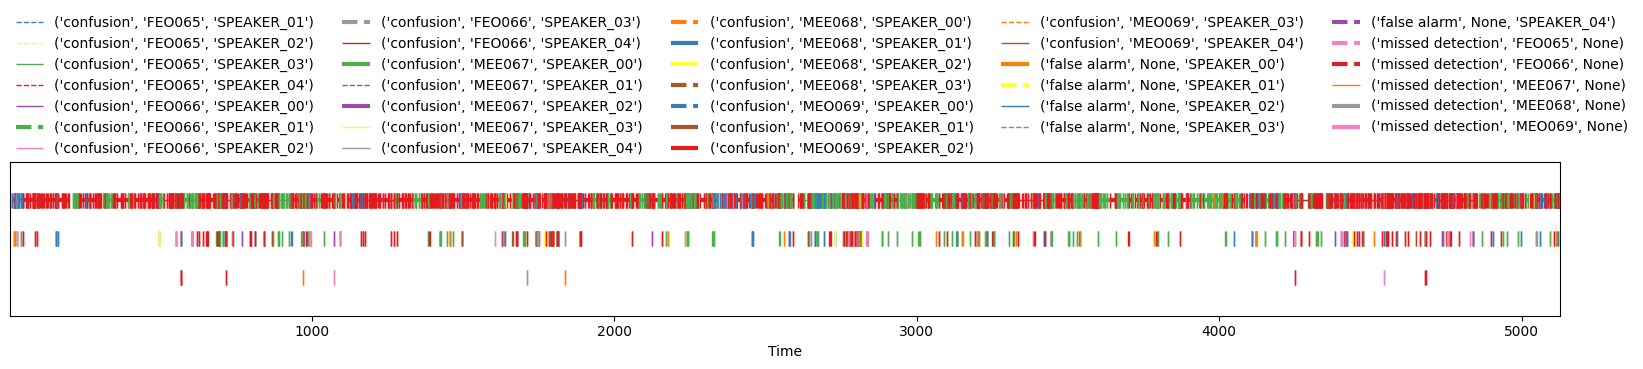

In [19]:
errors

# Interface for Human Feedback
I hypothesise that high confidence scores indicate that the annotation is the source of the error, and low confidence scores indicate that the model is the source.

Following this, we'll take errors with the highest and lowest scores to assess first.

Ideally this interface wouldn't be in a notebook, but building it here allows me to quickly test out the idea within the workflow.

In [25]:
import numpy as np
from pathlib import Path

frame_resolution = float(data["output"]["confidence"]["resolution"])
frame_conf = np.array(data["output"]["confidence"]["score"], dtype=np.float32) / 100.0
audio_path = Path("amicorpus/EN2001a/audio/EN2001a.Mix-Headset.wav")
if not audio_path.exists():
    raise FileNotFoundError(f"Missing audio file: {audio_path}")
extent_segment = hyp.get_timeline().extent()
annotation_end = extent_segment.end if extent_segment is not None else 0.0
audio_duration = max(frame_conf.size * frame_resolution, annotation_end)

WINDOW_RADIUS = 1.5 # tweak this value

hyp_segments_conf = [
    {
        "segment": Segment(float(seg["start"]), float(seg["end"])),
        "speaker": seg["speaker"],
        "confidence": {k: float(v) / 100.0 for k, v in (seg.get("confidence") or {}).items()},
    }
    for seg in data["output"]["diarization"]
]

def overlap_duration(segment_a, segment_b):
    return max(0.0, min(segment_a.end, segment_b.end) - max(segment_a.start, segment_b.start))

def frame_confidence_stats(segment):
    start_idx = max(int(np.floor(segment.start / frame_resolution)), 0)
    end_idx = min(int(np.ceil(segment.end / frame_resolution)), frame_conf.size)
    if end_idx <= start_idx:
        return None, None, None
    values = frame_conf[start_idx:end_idx]
    return float(values.min()), float(values.mean()), float(values.max())

def model_confidence_for(segment, hyp_label):
    if hyp_label is None:
        return None
    best = None
    best_overlap = 0.0
    for candidate in hyp_segments_conf:
        overlap = overlap_duration(segment, candidate["segment"])
        if overlap > best_overlap:
            best_overlap = overlap
            best = candidate
    if best is None:
        return None
    return best["confidence"].get(hyp_label)

error_records = []
for idx, (segment, _, label_info) in enumerate(errors.itertracks(yield_label=True)):
    err_type, ref_label, hyp_label = label_info
    frame_min, frame_mean, frame_max = frame_confidence_stats(segment)
    model_conf = model_confidence_for(segment, hyp_label)
    uncertainty = (
        1.0 - model_conf
        if model_conf is not None
        else 1.0 - frame_mean if frame_mean is not None else 1.0
    )
    center = 0.5 * (segment.start + segment.end)
    window_start = max(center - WINDOW_RADIUS, 0.0)
    window_end = min(center + WINDOW_RADIUS, audio_duration)
    error_records.append(
        {
            "id": idx,
            "segment": segment,
            "error_label": err_type,
            "ref_label": ref_label,
            "hyp_label": hyp_label,
            "model_confidence": model_conf,
            "frame_conf_mean": frame_mean,
            "frame_conf_min": frame_min,
            "frame_conf_max": frame_max,
            "uncertainty_score": float(uncertainty),
            "window": (window_start, window_end),
        }
    )

if not error_records:
    raise RuntimeError("No diarization errors available for review.")

uncertainties = np.array([rec["uncertainty_score"] for rec in error_records], dtype=np.float32)
high_threshold = float(np.quantile(uncertainties, 0.85))
low_threshold = float(np.quantile(uncertainties, 0.15))

# take top 25 highest and lowest confidence score errors
high_uncertain_ids = [
    rec["id"]
    for rec in sorted(error_records, key=lambda r: r["uncertainty_score"], reverse=True)
    if rec["uncertainty_score"] >= high_threshold
][:25]
low_uncertain_ids = [
    rec["id"]
    for rec in sorted(error_records, key=lambda r: r["uncertainty_score"])
    if rec["uncertainty_score"] <= low_threshold
][:25]

if not high_uncertain_ids:
    high_uncertain_ids = [
        rec["id"]
        for rec in sorted(error_records, key=lambda r: r["uncertainty_score"], reverse=True)
    ][: min(10, len(error_records))]
if not low_uncertain_ids:
    low_uncertain_ids = [
        rec["id"]
        for rec in sorted(error_records, key=lambda r: r["uncertainty_score"])
    ][: min(10, len(error_records))]

id_to_record = {rec["id"]: rec for rec in error_records}

In [26]:
import os
import uuid
from datetime import datetime
from functools import lru_cache
from pathlib import Path

import ipywidgets as widgets
import librosa
import numpy as np
import pandas as pd
from IPython.display import Audio, display

from pyannote.audio import Inference, Model

from scipy.spatial.distance import cdist

# SPEAKER_MODEL = Model.from_pretrained("pyannote/embedding")
# spk_inference = Inference(SPEAKER_MODEL, window="whole")

mpl_cache = Path(".matplotlib_cache")
mpl_cache.mkdir(exist_ok=True)
os.environ.setdefault("MPLCONFIGDIR", str(mpl_cache.resolve()))

import matplotlib.pyplot as plt

AUDIO_SR = 16000
EMBED_DURATION = 12.0
similarity_cache = {}

@lru_cache(maxsize=512)
def snippet_audio(start, duration):
    y, _ = librosa.load(audio_path.as_posix(), sr=AUDIO_SR, offset=float(start), duration=float(duration))
    return y

# mfcc similarity, would like to replace with pyannote xvec similarity, could be useful feature

# @lru_cache(maxsize=128)
# def speaker_embedding(source, label):
#     if not label:
#         return None
#     annotation = ref if source == "ref" else hyp
#     remaining = EMBED_DURATION
#     clips = []
#     for seg in annotation.label_timeline(label):
#         if remaining <= 0:
#             break
#         take = min(seg.duration, remaining)
#         if take <= 0:
#             continue
#         y, _ = librosa.load(
#             audio_path.as_posix(),
#             sr=AUDIO_SR,
#             offset=float(max(seg.start, 0.0)),
#             duration=float(take),
#         )
#         if y.size:
#             clips.append(y)
#             remaining -= take
#     if not clips:
#         return None
#     samples = np.concatenate(clips)
#     mfcc = librosa.feature.mfcc(y=samples, sr=AUDIO_SR, n_mfcc=24)
#     emb = mfcc.mean(axis=1)
#     norm = np.linalg.norm(emb)
#     if norm == 0:
#         return None
#     return emb / norm

# TODO: setup for xvec embedding similarity
# @lru_cache(maxsize=128)
# def speaker_embedding(source, label):
#     if not label:
#         return None

#     annotation = ref if source == "ref" else hyp
#     remaining = EMBED_DURATION
#     audio_chunks = []

#     for seg in annotation.label_timeline(label):
#         if remaining <= 0:
#             break

#         take = min(seg.duration, remaining)
#         if take <= 0:
#             continue

#         y, _ = librosa.load(
#             audio_path.as_posix(),
#             sr=AUDIO_SR,
#             offset=float(max(seg.start, 0.0)),
#             duration=float(take),
#         )
#         if y.size:
#             audio_chunks.append(y)
#             remaining -= take

#     if not audio_chunks:
#         return None

#     waveform = np.concatenate(audio_chunks)[None, :]  # shape: (1, T)

#     emb = spk_inference(waveform)  # shape (1, D)

#     return np.asarray(emb).reshape(-1)

# cosine distance of two embeddings
# def embedding_similarity(record):
#     cached = similarity_cache.get(record["id"])
#     if cached is not None:
#         return cached

#     if not (record["ref_label"] and record["hyp_label"]):
#         similarity_cache[record["id"]] = None
#         return None

#     ref_emb = speaker_embedding("ref", record["ref_label"])
#     hyp_emb = speaker_embedding("hyp", record["hyp_label"])

#     if ref_emb is None or hyp_emb is None:
#         similarity_cache[record["id"]] = None
#         return None

#     dist = float(cdist([ref_emb], [hyp_emb], metric="cosine")[0, 0])
#     similarity_cache[record["id"]] = dist
#     return dist

def audio_player_with_ms(samples):
    widget = Audio(data=samples, rate=AUDIO_SR)
    html = widget._repr_html_()
    audio_id = f"audio_{uuid.uuid4().hex}"
    timer_id = f"timer_{uuid.uuid4().hex}"
    if "<audio" in html:
        html = html.replace("<audio", f"<audio id='{audio_id}'", 1)
    html += f"""
    <div style='font-size:13px;'>t = <span id='{timer_id}'>0</span> ms</div>
    <script>
    (function() {{
        const audio = document.getElementById('{audio_id}');
        const timer = document.getElementById('{timer_id}');
        if (!audio || !timer) {{ return; }}
        function update() {{ timer.textContent = Math.round(audio.currentTime * 1000); }}
        audio.addEventListener('timeupdate', update);
        audio.addEventListener('play', update);
        audio.addEventListener('pause', update);
        audio.addEventListener('ended', () => {{ timer.textContent = Math.round((audio.duration || 0) * 1000); }});
    }})();
    </script>
    """
    return widgets.HTML(value=html)


def build_audio_widget(record):
    window_start, window_end = record["window"]
    duration = max(0.25, window_end - window_start)
    samples = snippet_audio(round(window_start, 3), round(duration, 3))
    player = audio_player_with_ms(samples)
    return player, window_start, window_end

def plot_error_timeline(record):
    window_start, window_end = record["window"]
    view = Segment(window_start, window_end)
    fig, ax = plt.subplots(figsize=(9, 2.6))
    series = [(ref, "Annotation", "#1f77b4"), (hyp, "Model", "#d62728")]
    for idx, (ann, label, color) in enumerate(series):
        cropped = ann.crop(view, mode="intersection")
        for seg, _, lbl in cropped.itertracks(yield_label=True):
            rel_start = max(seg.start, window_start) - window_start
            rel_end = min(seg.end, window_end) - window_start
            ax.plot([rel_start, rel_end], [idx, idx], color=color, linewidth=10, solid_capstyle="butt")
            ax.text((rel_start + rel_end) / 2, idx + 0.1, lbl, ha="center", va="bottom", fontsize=8, color=color)
    rel_error_start = record["segment"].start - window_start
    rel_error_end = record["segment"].end - window_start
    ax.axvspan(rel_error_start, rel_error_end, color="#ffdd57", alpha=0.35, label="Error span")
    ax.set_xlim(0, window_end - window_start)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Annotation", "Model"])
    ax.set_xlabel("Seconds (relative to snippet start)")
    ax.set_title(f"Segment {record['segment'].start:.2f}s–{record['segment'].end:.2f}s")
    ax.legend(loc="upper right")
    fig.tight_layout()
    return fig

def render_summary(record):
    def fmt_percent(value):
        return f"{value * 100:.1f}%" if value is not None else "N/A"

    #sim = embedding_similarity(record)
    info_lines = [
        f"<b>Error type:</b> {record['error_label']}",
        f"<b>Annotation:</b> {record['ref_label'] or 'None'}",
        f"<b>Model:</b> {record['hyp_label'] or 'None'}",
        f"<b>Model confidence:</b> {fmt_percent(record['model_confidence'])}",
        f"<b>Frame confidence:</b> mean {fmt_percent(record['frame_conf_mean'])} "
        f"(min {fmt_percent(record['frame_conf_min'])}, max {fmt_percent(record['frame_conf_max'])})",
    #    f"<b>Embedding similarity:</b> {sim:.3f}" if sim is not None else "<b>Embedding similarity:</b> N/A",
        f"<b>Uncertainty score:</b> {record['uncertainty_score']:.3f}",
    ]
    return "<br>".join(info_lines)


In [27]:
APP_STATE_KEY = "ERROR_REVIEW_APP_STATE"


def _close_widget(widget):
    if widget is None:
        return
    try:
        widget.close()
    except Exception:
        pass


_previous_state = globals().get(APP_STATE_KEY)
if _previous_state:
    for widget in _previous_state.get("widgets", []):
        _close_widget(widget)

feedback_store = {}
queue_map = {"high": high_uncertain_ids, "low": low_uncertain_ids}

queue_selector = widgets.ToggleButtons(
    options=[("High uncertainty", "high"), ("Low uncertainty", "low")],
    value="high",
    description="Review",
    button_style="info",
    layout=widgets.Layout(width="auto"),
)
queue_labels = {value: label for label, value in queue_selector.options}
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=max(len(queue_map["high"]) - 1, 0),
    description="Index",
    continuous_update=False,
    layout=widgets.Layout(width="300px"),
)
summary_label = widgets.HTML()

audio_output = widgets.Output()
snippet_hint = widgets.HTML()
viz_output = widgets.Output()
info_html = widgets.HTML()

question_html = widgets.HTML("<b>Is this error due to the model or due to an incorrect annotation?</b>")
response_widget = widgets.ToggleButtons(
    options=[
        ("Model error", "Model error"),
        ("Annotation error", "Annotation error"),
        ("Not sure / ambiguous", "Not sure / ambiguous"),
    ],
    layout=widgets.Layout(width="auto"),
)
response_widget.index = None
save_button = widgets.Button(description="Save response", button_style="success", icon="check")
next_button = widgets.Button(description="Next >>", icon="arrow-right")
status_html = widgets.HTML()
feedback_output = widgets.Output()
app_container = widgets.Output()
display(app_container)


def current_ids():
    return queue_map.get(queue_selector.value, [])


def current_record():
    ids = current_ids()
    if not ids:
        return None
    pos = min(index_slider.value, len(ids) - 1)
    return id_to_record[ids[pos]]


def refresh_slider(*_):
    ids = current_ids()
    if ids:
        index_slider.max = len(ids) - 1
        index_slider.disabled = False
        if index_slider.value > index_slider.max:
            index_slider.value = index_slider.max
    else:
        index_slider.max = 0
        index_slider.value = 0
        index_slider.disabled = True
    summary_label.value = (
        f"<b>{queue_labels.get(queue_selector.value, queue_selector.value.title())}</b>: {len(ids)} examples"
    )


def update_feedback_table():
    if not feedback_store:
        with feedback_output:
            feedback_output.clear_output()
            display(pd.DataFrame(columns=["error_id", "choice", "queue", "timestamp"]))
        return
    rows = []
    for error_id, payload in feedback_store.items():
        record = id_to_record[error_id]
        rows.append(
            {
                "error_id": error_id,
                "error_type": record["error_label"],
                "annotation": record["ref_label"],
                "model": record["hyp_label"],
                "choice": payload["choice"],
                "queue": payload["queue"],
                "timestamp": payload["timestamp"],
            }
        )
    df = pd.DataFrame(rows).sort_values("timestamp", ascending=False)
    with feedback_output:
        feedback_output.clear_output()
        display(df)


def update_view(*_):
    record = current_record()
    if record is None:
        with audio_output:
            audio_output.clear_output()
        with viz_output:
            viz_output.clear_output()
        info_html.value = "<i>No examples available for this bucket.</i>"
        snippet_hint.value = ""
        status_html.value = ""
        response_widget.index = None
        return
    audio_widget, window_start, window_end = build_audio_widget(record)
    rel_start = max(record["segment"].start - window_start, 0.0)
    rel_end = max(record["segment"].end - window_start, rel_start)
    audio_output.clear_output(wait=True)
    with audio_output:  
        display(audio_widget)
    snippet_hint.value = (
        f"<b>Snippet:</b> {window_start:.2f}s–{window_end:.2f}s &nbsp;"
        f"(<span style='color:#d62728;'>error spans {rel_start:.2f}s–{rel_end:.2f}s</span> in this audio)"
    )
    viz_output.clear_output(wait=True)
    with viz_output:
        fig = plot_error_timeline(record)
        display(fig)
    plt.close(fig)
    info_html.value = render_summary(record)
    stored = feedback_store.get(record["id"])
    if stored:
        response_widget.value = stored["choice"]
    else:
        response_widget.index = None
    status_html.value = (
        f"Viewing error #{record['id']} ({queue_labels.get(queue_selector.value, queue_selector.value)} queue)"
    )


def handle_save(_):
    record = current_record()
    choice = response_widget.value
    if record is None:
        status_html.value = "<span style='color:#d62728;'>No example available.</span>"
        return
    if choice is None:
        status_html.value = "<span style='color:#d62728;'>Select an option before saving.</span>"
        return
    feedback_store[record["id"]] = {
        "choice": choice,
        "queue": queue_selector.value,
        "timestamp": datetime.utcnow().isoformat(timespec="seconds"),
    }
    status_html.value = f"Saved {choice} for error #{record['id']}."
    update_feedback_table()


def handle_next(_):
    audio_output.clear_output(wait=True)
    ids = current_ids()
    if not ids:
        return
    next_idx = 0 if index_slider.value >= len(ids) - 1 else index_slider.value + 1
    index_slider.value = next_idx


queue_selector.observe(refresh_slider, names="value")
queue_selector.observe(update_view, names="value")
index_slider.observe(update_view, names="value")
save_button.on_click(handle_save)
next_button.on_click(handle_next)

refresh_slider()
update_feedback_table()
update_view()

controls_row = widgets.HBox(
    [queue_selector, index_slider, summary_label],
    layout=widgets.Layout(align_items="center", justify_content="space-between", width="100%"),
)
left_panel = widgets.VBox(
    [audio_output, snippet_hint, viz_output, info_html],
    layout=widgets.Layout(width="65%", padding="8px", border="1px solid #ddd"),
)
right_panel = widgets.VBox(
    [question_html, response_widget, save_button, next_button, status_html],
    layout=widgets.Layout(width="35%", padding="8px", border="1px solid #ddd"),
)
saved_responses_header = widgets.HTML("<b>Saved responses</b>")
app = widgets.VBox(
    [
        controls_row,
        widgets.HBox([left_panel, right_panel], layout=widgets.Layout(width="100%")),
        saved_responses_header,
        feedback_output,
    ],
    layout=widgets.Layout(width="100%", gap="10px"),
)

with app_container:
    app_container.clear_output(wait=True)
    display(app)

globals()[APP_STATE_KEY] = {
    "container": app_container,
    "widgets": [
        app_container,
        queue_selector,
        index_slider,
        summary_label,
        audio_output,
        snippet_hint,
        viz_output,
        info_html,
        question_html,
        response_widget,
        save_button,
        next_button,
        status_html,
        feedback_output,
        controls_row,
        left_panel,
        right_panel,
        saved_responses_header,
        app,
    ],
}



Output()

The saved responses are random. There are plenty of ways the interface could be improved, and that time would be best spent building it up in a web app rather the notebook. However, this does show that we can extract, isolate, and prioritise errors and present a quick binary option for a user to assess.

### Adding features to record alongside human feedback

In order to analyse errors, context surrounding them could be useful:
- Error type (missed detection, false alarm, confusion)
- Embedding similarity (x-vectors in progress)
- Duration of the error
- Number of speakers in window and whether there is overlap (could also use Pyannote overlap model?)
- To target missed detections and false alarms, could look at energy via signal to noise and VAD.
- Could pull in transcript text from AMI corpus to show alongside error

### Future Steps
- Would like to analyse feature differences between annotation/model errors
- Supervised classification once enough features are collected + automated annotation correction could be useful

- Assessing confusion errors is difficult when faced with abstract labels. Could play example segments that are agreed upon by both model and annotation of the given speakers to choose from. This could possibly slow annotation though?